# MNIST Neural Network Classifier (MLP)

This implementation uses a fully connected neural network (MLP) rather than a CNN to classify MNIST digits. This approach:
- Flattens the 28x28 images into 784-dimensional vectors
- Processes through fully connected layers
- Demonstrates core neural network concepts without convolutions

Key features:
- Custom MLP implementation with manual forward/backward propagation
- Comparison of different hyper-parameters and initializations
- Single example and batch processing implementations
- Cross-entropy loss from scratch

## Architecture Details

...

## Implementation Notes

This implementation intentionally uses an MLP instead of a CNN to:
- Demonstrate fundamental neural network concepts
- Show how images can be processed as flat vectors
- Provide a baseline for comparing against CNN implementations

In [1]:
# Imports

import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
# Load the MNIST dataset

transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset size:", len(trainset))
print("testset size:", len(testset))


trainset size: 60000
testset size: 10000


In [3]:
# Shape of an example

ex = trainset[0][0]
print(f"{ex.shape=}")


ex.shape=torch.Size([1, 28, 28])


In [4]:
# All labels in training set

classes = set([y for _, y in trainset])
classes


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
def show_imgs(imgs):
    """
    Show images in a row
    """
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return imgs_label


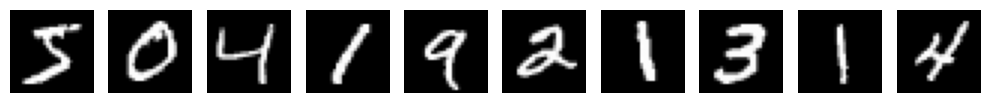

labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [6]:
sample_imgs = [trainset[i] for i in range(10)]
print(f"labels: {show_imgs(sample_imgs)}")


## MLP Classifier Implementation

This Multi-Layer Perceptron:
1. Flattens each 28x28 image into a 784-dimensional vector
2. Processes through a fully connected hidden layer with ReLU activation
3. Outputs probabilities for each digit (0-9) using softmax

Note: While CNNs are typically more effective for image tasks, this MLP implementation demonstrates core neural network principles and provides a useful baseline.

In [7]:
torch.manual_seed(42)
np.random.seed(42)


In [8]:
class MLPClassifier:
    def __init__(self, lr, input_dim=784, hidden_dim=128, output_dim=10, xavier_init=True):
        self.lr = lr
        self.init_type = 'xavier' if xavier_init else 'random'

        if xavier_init:
            # uniform Xavier init
            x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
            x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

            self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
            self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        else:
            # random init
            scale = 0.01
            self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim) * scale, requires_grad=True)
            self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim) * scale, requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, y_true):
        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, x):
        self.x = x
        return self.forward()


In [9]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = torch.tensor(np.float64(trainset[0][0].reshape(784)))


In [11]:
def cross_entropy(out, y):
    """
    Cross entropy loss: -sum(true_class_distribution * log(predicted_class_distribution))
    - y is the true class (scalar), requires one-hot encoding
        - ex. if y is 2 then y_ohe represents class probability distribution of 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    """
    y_ohe = torch.zeros_like(out)
    y_ohe[y] = 1.0

    return np.float64(-torch.sum(y_ohe * torch.log(out +1e-10)))


In [12]:
def criterion(y_pred, y_true, loss_fn):
    """
    Compute loss for a single example
    """
    return loss_fn(y_pred, y_true)


In [13]:
# Test the loss functions

y_true = 5
y_pred1 = torch.tensor([0.2, 0.1, 0.2, 0.1, 0.1, 0.3, 0.1, 0.1, 0.1, 0.1])
y_pred2 = torch.tensor([0.0529, 0.0529, 0.0529, 0.0529, 0.0529, 0.5238, 0.0529, 0.0529, 0.0529,
        0.0529])

print(f"Cross-entropy loss between {y_true} and y_pred1:", criterion(y_pred1, y_true, cross_entropy))
print(f"Cross-entropy loss between {y_true} and y_pred2:", criterion(y_pred2, y_true, cross_entropy))


Cross-entropy loss between 5 and y_pred1: 1.2039728164672852
Cross-entropy loss between 5 and y_pred2: 0.6466453075408936


In [14]:
LEARNING_RATE = 0.001
EPOCHS = 5
experiment_results = {
    f'random_init_lr{LEARNING_RATE}_e{EPOCHS}': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    f'xavier_init_lr{LEARNING_RATE}_e{EPOCHS}': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    'batch_model_lr0.9_e5': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    'batch_scheduled_model_e5': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    'batch_dropout_model_lr0.9_e5': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    'deep_model_e5': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
}


In [146]:
random_init_model = MLPClassifier(LEARNING_RATE, xavier_init=False) # use as baseline model
xavier_init_model = MLPClassifier(LEARNING_RATE, xavier_init=True)


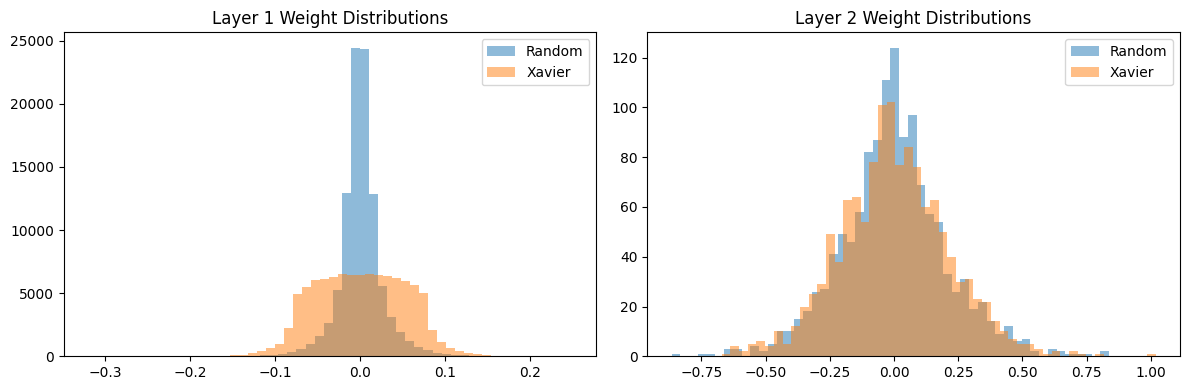

In [141]:
# Compare random vs Xavier init
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(random_init_model.W1.detach().numpy().flatten(), bins=50, alpha=0.5, label='Random')
plt.hist(xavier_init_model.W1.detach().numpy().flatten(), bins=50, alpha=0.5, label='Xavier')
plt.title('Layer 1 Weight Distributions')
plt.legend()

plt.subplot(122)
plt.hist(random_init_model.W2.detach().numpy().flatten(), bins=50, alpha=0.5, label='Random')
plt.hist(xavier_init_model.W2.detach().numpy().flatten(), bins=50, alpha=0.5, label='Xavier')
plt.title('Layer 2 Weight Distributions')
plt.legend()

plt.tight_layout()
plt.show()


In [150]:
for epoch in range(EPOCHS):
    start = time.time()
    epoch_loss = 0

    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = dummy(x)

        loss = criterion(output, label, cross_entropy)
        epoch_loss += loss
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    end = time.time()
    delta = end - start
    avg_loss = epoch_loss / len(trainset)
    experiment_results[f'dummy']['train_losses'].append(avg_loss)
    experiment_results[f'dummy']['epoch_times'].append(delta)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Epoch [1/5], Step [0/60000], Loss: 2.4776
Epoch [1/5], Step [1000/60000], Loss: 2.3994
Epoch [1/5], Step [2000/60000], Loss: 2.5558
Epoch [1/5], Step [3000/60000], Loss: 2.3971
Epoch [1/5], Step [4000/60000], Loss: 2.0308
Epoch [1/5], Step [5000/60000], Loss: 1.9517
Epoch [1/5], Step [6000/60000], Loss: 2.4074
Epoch [1/5], Step [7000/60000], Loss: 2.2477
Epoch [1/5], Step [8000/60000], Loss: 2.2746
Epoch [1/5], Step [9000/60000], Loss: 2.6219
Epoch [1/5], Step [10000/60000], Loss: 2.4331
Epoch [1/5], Step [11000/60000], Loss: 2.4408
Epoch [1/5], Step [12000/60000], Loss: 1.9681
Epoch [1/5], Step [13000/60000], Loss: 2.1878
Epoch [1/5], Step [14000/60000], Loss: 2.3745
Epoch [1/5], Step [15000/60000], Loss: 2.5776
Epoch [1/5], Step [16000/60000], Loss: 2.4835
Epoch [1/5], Step [17000/60000], Loss: 2.5727
Epoch [1/5], Step [18000/60000], Loss: 2.2331
Epoch [1/5], Step [19000/60000], Loss: 2.3769
Epoch [1/5], Step [20000/60000], Loss: 2.4594
Epoch [1/5], Step [21000/60000], Loss: 2.2399
E

In [17]:
for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Training model with {init_type} initialization")
    for epoch in range(EPOCHS):
        start = time.time()
        epoch_loss = 0
    
        for i in range(len(trainset)):
            img, label = trainset[i]
            x = torch.tensor(np.float64(img.reshape(784)))
    
            output = model(x)
    
            loss = criterion(output, label, cross_entropy)
            epoch_loss += loss
            
            model.backward(label)
            
            if i % 1000 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
        end = time.time()
        delta = end - start
        avg_loss = epoch_loss / len(trainset)
        experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_losses'].append(avg_loss)
        experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['epoch_times'].append(delta)
        print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Training model with random initialization
Epoch [1/5], Step [0/60000], Loss: 2.3009
Epoch [1/5], Step [1000/60000], Loss: 2.2747
Epoch [1/5], Step [2000/60000], Loss: 2.3216
Epoch [1/5], Step [3000/60000], Loss: 2.3337
Epoch [1/5], Step [4000/60000], Loss: 1.9673
Epoch [1/5], Step [5000/60000], Loss: 1.7238
Epoch [1/5], Step [6000/60000], Loss: 1.1882
Epoch [1/5], Step [7000/60000], Loss: 1.7059
Epoch [1/5], Step [8000/60000], Loss: 0.1642
Epoch [1/5], Step [9000/60000], Loss: 0.7934
Epoch [1/5], Step [10000/60000], Loss: 0.3416
Epoch [1/5], Step [11000/60000], Loss: 0.1151
Epoch [1/5], Step [12000/60000], Loss: 0.3456
Epoch [1/5], Step [13000/60000], Loss: 0.6183
Epoch [1/5], Step [14000/60000], Loss: 0.1493
Epoch [1/5], Step [15000/60000], Loss: 0.8546
Epoch [1/5], Step [16000/60000], Loss: 0.0955
Epoch [1/5], Step [17000/60000], Loss: 0.5200
Epoch [1/5], Step [18000/60000], Loss: 0.2726
Epoch [1/5], Step [19000/60000], Loss: 0.4031
Epoch [1/5], Step [20000/60000], Loss: 0.0429
Epoch

In [18]:
# Calculate mean and variance of losses

for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    model_name = f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}'
    n = len(experiment_results[model_name]['train_losses'])
    all_losses = experiment_results[model_name]['train_losses']
    mean = sum(all_losses) / n

    var = sum((x - mean) ** 2 for x in all_losses) / n
    experiment_results[model_name]['loss_metrics']['mean_train_loss'] = mean
    experiment_results[model_name]['loss_metrics']['variance_train_loss'] = var
    print(f"{model_name} mean loss: {mean:.4f}, variance loss: {var:.4f}")


random_init_lr0.001_e5 mean loss: 0.3056, variance loss: 0.0318
xavier_init_lr0.001_e5 mean loss: 0.2583, variance loss: 0.0160


In [19]:
def plot_losses(losses):
    """
    Plot losses for each model
    """
    plt.figure(figsize=(10, 5))
    for model_name, loss in losses.items():
        plt.plot(loss, label=model_name)
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.show()


In [ ]:
for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Testing model on train with {init_type} initialization")

    train_loss = 0
    correct = 0

    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = model(x)
        loss = criterion(output, label, cross_entropy)
        train_loss += loss

        pred = torch.argmax(output)
        correct += (pred == label).item()

        if i % 1000 == 0:
            print(f'Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_train_loss = train_loss / len(trainset)
    accuracy = 100 * correct / len(trainset)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_losses'].append(avg_train_loss)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_accuracy'] = accuracy

    print(f'{avg_train_loss=:.4f}, {accuracy=:.2f}%')


Testing model on train with random initialization
Step [0/60000], Loss: 0.0212
Step [1000/60000], Loss: 0.0110
Step [2000/60000], Loss: 0.1212
Step [3000/60000], Loss: 0.0475
Step [4000/60000], Loss: 0.0036
Step [5000/60000], Loss: 0.3497
Step [6000/60000], Loss: 0.0025
Step [7000/60000], Loss: 0.4121
Step [8000/60000], Loss: 0.0000
Step [9000/60000], Loss: 0.0016
Step [10000/60000], Loss: 0.0008
Step [11000/60000], Loss: 0.0005
Step [12000/60000], Loss: 0.0326
Step [13000/60000], Loss: 0.0372
Step [14000/60000], Loss: 0.0020
Step [15000/60000], Loss: 0.0069
Step [16000/60000], Loss: 0.0001
Step [17000/60000], Loss: 0.0044
Step [18000/60000], Loss: 0.0994
Step [19000/60000], Loss: 0.0038
Step [20000/60000], Loss: 0.0001
Step [21000/60000], Loss: 0.4327
Step [22000/60000], Loss: 0.1467
Step [23000/60000], Loss: 0.0002
Step [24000/60000], Loss: 0.0021
Step [25000/60000], Loss: 0.2894
Step [26000/60000], Loss: 0.0568
Step [27000/60000], Loss: 0.3177
Step [28000/60000], Loss: 0.0064
Step [

In [21]:
for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Testing model on test with {init_type} initialization")

    test_loss = 0
    correct = 0

    for i in range(len(testset)):
        img, label = testset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = model(x)
        loss = criterion(output, label, cross_entropy)
        test_loss += loss

        pred = torch.argmax(output)
        correct += (pred == label).item()

        if i % 1000 == 0:
            print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

    avg_test_loss = test_loss / len(testset)
    accuracy = 100 * correct / len(testset)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['test_losses'].append(avg_test_loss)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['test_accuracy'] = accuracy

    print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')


Testing model on test with random initialization
Step [0/10000], Loss: 0.0050
Step [1000/10000], Loss: 0.0249
Step [2000/10000], Loss: 0.0162
Step [3000/10000], Loss: 0.0280
Step [4000/10000], Loss: 1.7213
Step [5000/10000], Loss: 0.0583
Step [6000/10000], Loss: 0.0511
Step [7000/10000], Loss: 0.0083
Step [8000/10000], Loss: 0.0000
Step [9000/10000], Loss: 0.0006
avg_test_loss=0.1580, accuracy=95.22%
Testing model on test with xavier initialization
Step [0/10000], Loss: 0.0042
Step [1000/10000], Loss: 0.0491
Step [2000/10000], Loss: 0.0273
Step [3000/10000], Loss: 0.0366
Step [4000/10000], Loss: 1.0334
Step [5000/10000], Loss: 0.0478
Step [6000/10000], Loss: 0.0538
Step [7000/10000], Loss: 0.0077
Step [8000/10000], Loss: 0.0000
Step [9000/10000], Loss: 0.0006
avg_test_loss=0.1439, accuracy=95.57%


In [22]:
results = {}

for k, v in experiment_results.items():
    results[k] = {
        'train_accuracy': v['train_accuracy'],
        'test_accuracy': v['test_accuracy'],
    }

results_df = pd.DataFrame(results)
results_df


,random_init_lr0.001_e5,xavier_init_lr0.001_e5,batch_model_lr0.9_e5,batch_scheduled_model_e5,batch_dropout_model_lr0.9_e5
train_accuracy,95.538333,96.07,0,0,0
test_accuracy,95.220000,95.57,0,0,0


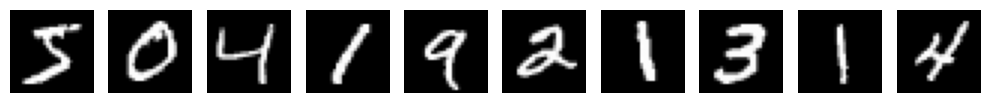

,actual,predicted
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


In [23]:
# Let's use the original sample images
show_imgs(sample_imgs)

pred = {
    "actual": [y for _, y in sample_imgs],
    "predicted": [torch.argmax(xavier_init_model(torch.tensor(np.float64(img.reshape(784))))).item() for img, _ in sample_imgs]
}
pred_df = pd.DataFrame(pred)
pred_df


In [24]:
class BatchMLPClassifier:
    def __init__(self, lr, input_dim=784, hidden_dim=128, output_dim=10):
        self.lr = lr
        # uniform Xavier init
        x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
        x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

        self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
        self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.X.T + self.w1.unsqueeze(1)
        self.y1 = torch.relu(self.h1) + self.b1.unsqueeze(1)

        self.h2 = self.W2 @ self.y1 + self.w2.unsqueeze(1)
        self.h2 = self.h2 - torch.max(self.h2, dim=0)[0].unsqueeze(0)
        exp_h2 = torch.exp(self.h2)
        self.y2 = exp_h2 / (torch.sum(exp_h2, dim=0).unsqueeze(0) + 1e-8)
        return self.y2.T

    def backward(self, Y_true):
        batch_size = len(Y_true)

        # Compute gradients
        dy2 = self.y2.clone()
        dy2.T[range(batch_size), Y_true] -= 1 
    
        # Gradients for second layer 
        dW2 = dy2 @ self.y1.T / batch_size
        dw2 = dy2.mean(dim=1)
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = dh1 @ self.X / batch_size
        dw1 = dh1.mean(dim=1)
        db1 = dy1.mean(dim=1)
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, X):
        self.X = X
        return self.forward()


In [25]:
def batch_cross_entropy(out, y):
    """
    Batched cross entropy loss
    Args:
        out: shape (batch_size, num_classes) - predicted probabilities
        y: shape (batch_size,) - true class indices
    Returns:
        Average loss over the batch
    """
    batch_size = len(y)
    y_ohe = torch.zeros_like(out)
    y_ohe[range(batch_size), y] = 1.0

    return np.float64(-torch.sum(y_ohe * torch.log(out + 1e-10)) / batch_size)


In [26]:
batch_model = BatchMLPClassifier(0.9)


In [27]:
for epoch in range(EPOCHS):
    start = time.time()
    epoch_loss = 0
    for i, (imgs, labels) in enumerate(trainloader):
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        Y = labels
        
        output = batch_model(X)
        loss = criterion(output, Y, batch_cross_entropy)
        epoch_loss += loss.item() * len(Y)
        
        batch_model.backward(Y)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    
    end = time.time()
    delta = end - start
    avg_loss = epoch_loss / len(trainset)
    experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['train_losses'].append(avg_loss)
    experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['epoch_times'].append(delta)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Epoch [1/5], Step [0/60000], Loss: 2.3197
Epoch [1/5], Step [100/60000], Loss: 0.2550
Epoch [1/5], Step [200/60000], Loss: 0.3102
Epoch [1/5], Step [300/60000], Loss: 0.1637
Epoch [1/5], Step [400/60000], Loss: 0.1745
Epoch [1/5], Average Loss: 0.3181
Epoch [2/5], Step [0/60000], Loss: 0.1110
Epoch [2/5], Step [100/60000], Loss: 0.0958
Epoch [2/5], Step [200/60000], Loss: 0.0711
Epoch [2/5], Step [300/60000], Loss: 0.1344
Epoch [2/5], Step [400/60000], Loss: 0.1175
Epoch [2/5], Average Loss: 0.1187
Epoch [3/5], Step [0/60000], Loss: 0.1033
Epoch [3/5], Step [100/60000], Loss: 0.0550
Epoch [3/5], Step [200/60000], Loss: 0.0969
Epoch [3/5], Step [300/60000], Loss: 0.0173
Epoch [3/5], Step [400/60000], Loss: 0.0691
Epoch [3/5], Average Loss: 0.0861
Epoch [4/5], Step [0/60000], Loss: 0.0425
Epoch [4/5], Step [100/60000], Loss: 0.0855
Epoch [4/5], Step [200/60000], Loss: 0.0424
Epoch [4/5], Step [300/60000], Loss: 0.0691
Epoch [4/5], Step [400/60000], Loss: 0.1369
Epoch [4/5], Average Loss:

In [28]:
train_loss = 0
correct = 0

for imgs, labels in trainloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    train_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_train_loss = train_loss / len(trainset)
accuracy = 100 * correct / len(trainset)
experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['train_losses'].append(avg_train_loss)
experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['train_accuracy'] = accuracy

print(f'Train loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%')


Train loss: 0.0469, Accuracy: 98.55%


In [29]:
test_loss = 0
correct = 0

for imgs, labels in testloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    test_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['test_losses'].append(avg_test_loss)
experiment_results[f'batch_model_lr{batch_model.lr}_e{EPOCHS}']['test_accuracy'] = accuracy

print(f'Test loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Test loss: 0.0913, Accuracy: 97.26%


In [30]:
class ScheduledMLPClassifier(BatchMLPClassifier):
    def __init__(self, initial_lr=0.9, final_lr=0.001, input_dim=784, hidden_dim=128, output_dim=10):
        super().__init__(initial_lr, input_dim, hidden_dim, output_dim)
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        
    def update_learning_rate(self, epoch, num_epochs):
        """Update learning rate using cosine annealing schedule"""
        self.lr = self.final_lr + 0.5 * (self.initial_lr - self.final_lr) * \
                 (1 + np.cos(epoch / num_epochs * np.pi))
        return self.lr


In [31]:
batch_scheduled_model = ScheduledMLPClassifier()


In [32]:
for epoch in range(EPOCHS):
    current_lr = batch_scheduled_model.update_learning_rate(epoch, EPOCHS)
    start = time.time()
    epoch_loss = 0
    for i, (imgs, labels) in enumerate(trainloader):
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        Y = labels
        
        output = batch_scheduled_model(X)
        loss = criterion(output, Y, batch_cross_entropy)
        epoch_loss += loss.item() * len(Y)
        
        batch_scheduled_model.backward(Y)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    
    end = time.time()
    delta = end - start
    avg_loss = epoch_loss / len(trainset)
    experiment_results[f'batch_scheduled_model_e{EPOCHS}']['train_losses'].append(avg_loss)
    experiment_results[f'batch_scheduled_model_e{EPOCHS}']['epoch_times'].append(delta)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Epoch [1/5], Step [0/60000], Loss: 2.3075
Epoch [1/5], Step [100/60000], Loss: 0.4886
Epoch [1/5], Step [200/60000], Loss: 0.1402
Epoch [1/5], Step [300/60000], Loss: 0.2090
Epoch [1/5], Step [400/60000], Loss: 0.2746
Epoch [1/5], Average Loss: 0.3071
Epoch [2/5], Step [0/60000], Loss: 0.0810
Epoch [2/5], Step [100/60000], Loss: 0.0997
Epoch [2/5], Step [200/60000], Loss: 0.0751
Epoch [2/5], Step [300/60000], Loss: 0.1139
Epoch [2/5], Step [400/60000], Loss: 0.1005
Epoch [2/5], Average Loss: 0.1113
Epoch [3/5], Step [0/60000], Loss: 0.0303
Epoch [3/5], Step [100/60000], Loss: 0.1148
Epoch [3/5], Step [200/60000], Loss: 0.0343
Epoch [3/5], Step [300/60000], Loss: 0.0346
Epoch [3/5], Step [400/60000], Loss: 0.0861
Epoch [3/5], Average Loss: 0.0748
Epoch [4/5], Step [0/60000], Loss: 0.0774
Epoch [4/5], Step [100/60000], Loss: 0.0716
Epoch [4/5], Step [200/60000], Loss: 0.0624
Epoch [4/5], Step [300/60000], Loss: 0.0206
Epoch [4/5], Step [400/60000], Loss: 0.0188
Epoch [4/5], Average Loss:

In [33]:
train_loss = 0
correct = 0

for imgs, labels in trainloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_scheduled_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    train_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_train_loss = train_loss / len(trainset)
accuracy = 100 * correct / len(trainset)
experiment_results[f'batch_scheduled_model_e{EPOCHS}']['train_losses'].append(avg_train_loss)
experiment_results[f'batch_scheduled_model_e{EPOCHS}']['train_accuracy'] = accuracy

print(f'Train loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%')


Train loss: 0.0415, Accuracy: 98.89%


In [34]:
test_loss = 0
correct = 0

for imgs, labels in testloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_scheduled_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    test_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
experiment_results[f'batch_scheduled_model_e{EPOCHS}']['test_losses'].append(avg_test_loss)
experiment_results[f'batch_scheduled_model_e{EPOCHS}']['test_accuracy'] = accuracy

print(f'Test loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Test loss: 0.0702, Accuracy: 97.78%


In [35]:
results_df['batch_model_lr0.9_e5'] = {
    'train_accuracy': experiment_results['batch_model_lr0.9_e5']['train_accuracy'],
    'test_accuracy': experiment_results['batch_model_lr0.9_e5']['test_accuracy'],
}
results_df


,random_init_lr0.001_e5,xavier_init_lr0.001_e5,batch_model_lr0.9_e5,batch_scheduled_model_e5,batch_dropout_model_lr0.9_e5
train_accuracy,95.538333,96.07,98.546667,0,0
test_accuracy,95.220000,95.57,97.260000,0,0


In [36]:
def plot_accuracy(experiment_results, accuracy_type):
   plt.figure(figsize=(10, 5))
   
   for i, (model, results) in enumerate(experiment_results.items()):
       plt.scatter(i, results[accuracy_type], 
                  marker="o", s=50, label=model)
       plt.annotate(f"{model}\n{results[accuracy_type]:.2f}%",
                   (i, results[accuracy_type]),
                   xytext=(5, 8), textcoords='offset points', fontsize=9)
                  
   plt.ylabel(f'{accuracy_type} (%)')
   plt.tight_layout()
   plt.show()


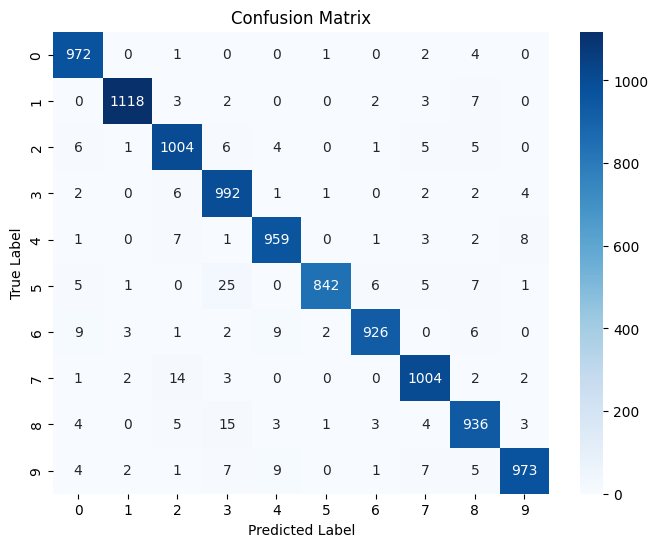

In [37]:
def plot_confusion_matrix(model, testloader):
    """
    Plot confusion matrix for model predictions on test set
    """
    all_preds = []
    all_labels = []
    
    for imgs, labels in testloader:
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        output = model(X)
        preds = torch.argmax(output, dim=1)
        
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(batch_model, testloader)


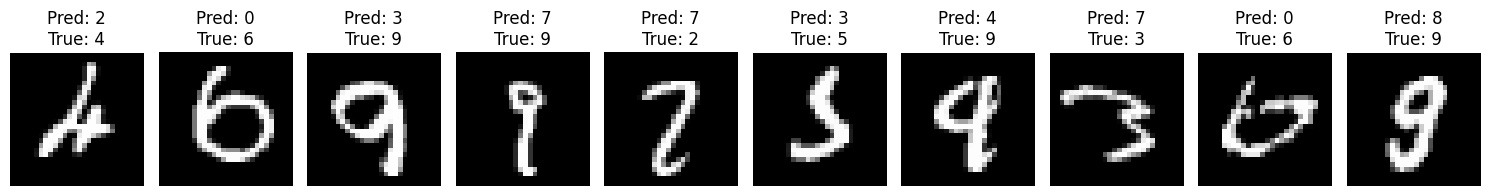

In [38]:
def plot_misclassified_examples(model, testloader, num_examples=10):
    """
    Plot examples of misclassified digits
    """
    misclassified = []
    
    for imgs, labels in testloader:
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        output = model(X)
        preds = torch.argmax(output, dim=1)
        
        # Find misclassified examples
        incorrect = preds != labels
        if incorrect.any():
            incorrect_indices = torch.where(incorrect)[0]
            for idx in incorrect_indices:
                misclassified.append({
                    'image': imgs[idx],
                    'pred': preds[idx].item(),
                    'true': labels[idx].item()
                })
                if len(misclassified) >= num_examples:
                    break
        if len(misclassified) >= num_examples:
            break
    
    # Plot misclassified examples
    plt.figure(figsize=(15, 3))
    for i, example in enumerate(misclassified[:num_examples]):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(example['image'].reshape(28, 28), cmap='gray')
        plt.title(f'Pred: {example["pred"]}\nTrue: {example["true"]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified_examples(batch_model, testloader)


In [39]:
class BatchMLPClassifierWithDropout(BatchMLPClassifier):
    def __init__(self, lr, input_dim=784, hidden_dim=128, output_dim=10, dropout_rate=0.25):
        super().__init__(lr, input_dim, hidden_dim, output_dim)
        self.dropout_rate = dropout_rate
        self.training = True    # Needed since we don't want dropouts during inference
        
    def forward(self):
        self.h1 = self.W1 @ self.X.T + self.w1.unsqueeze(1)
        self.y1 = torch.relu(self.h1) + self.b1.unsqueeze(1)
        
        # Apply dropout to y1 during training
        if self.training and self.dropout_rate > 0:
            self.dropout_mask = torch.bernoulli(
                torch.ones_like(self.y1) * (1 - self.dropout_rate)
            ) / (1 - self.dropout_rate)
            self.y1 = self.y1 * self.dropout_mask
        
        self.h2 = self.W2 @ self.y1 + self.w2.unsqueeze(1)
        self.h2 = self.h2 - torch.max(self.h2, dim=0)[0].unsqueeze(0)
        exp_h2 = torch.exp(self.h2)
        self.y2 = exp_h2 / (torch.sum(exp_h2, dim=0).unsqueeze(0) + 1e-8)
        return self.y2.T
    
    def train(self):
        """Set model to training mode"""
        self.training = True
        
    def eval(self):
        """Set model to evaluation mode"""
        self.training = False


In [40]:
batch_dropout_model = BatchMLPClassifierWithDropout(0.9, dropout_rate=0.1)
batch_dropout_model.train()


In [41]:
for epoch in range(EPOCHS):
    start = time.time()
    epoch_loss = 0
    for i, (imgs, labels) in enumerate(trainloader):
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        Y = labels
        
        output = batch_dropout_model(X)
        loss = criterion(output, Y, batch_cross_entropy)
        epoch_loss += loss.item() * len(Y)
        
        batch_dropout_model.backward(Y)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    
    end = time.time()
    delta = end - start
    avg_loss = epoch_loss / len(trainset)
    experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['train_losses'].append(avg_loss)
    experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['epoch_times'].append(delta)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Epoch [1/5], Step [0/60000], Loss: 2.3242
Epoch [1/5], Step [100/60000], Loss: 0.5564
Epoch [1/5], Step [200/60000], Loss: 0.1226
Epoch [1/5], Step [300/60000], Loss: 0.0768
Epoch [1/5], Step [400/60000], Loss: 0.1932
Epoch [1/5], Average Loss: 0.3095
Epoch [2/5], Step [0/60000], Loss: 0.1706
Epoch [2/5], Step [100/60000], Loss: 0.1124
Epoch [2/5], Step [200/60000], Loss: 0.2124
Epoch [2/5], Step [300/60000], Loss: 0.1360
Epoch [2/5], Step [400/60000], Loss: 0.0757
Epoch [2/5], Average Loss: 0.1274
Epoch [3/5], Step [0/60000], Loss: 0.1009
Epoch [3/5], Step [100/60000], Loss: 0.0441
Epoch [3/5], Step [200/60000], Loss: 0.1146
Epoch [3/5], Step [300/60000], Loss: 0.0754
Epoch [3/5], Step [400/60000], Loss: 0.0583
Epoch [3/5], Average Loss: 0.1003
Epoch [4/5], Step [0/60000], Loss: 0.1004
Epoch [4/5], Step [100/60000], Loss: 0.1322
Epoch [4/5], Step [200/60000], Loss: 0.1046
Epoch [4/5], Step [300/60000], Loss: 0.1387
Epoch [4/5], Step [400/60000], Loss: 0.0424
Epoch [4/5], Average Loss:

In [42]:
batch_dropout_model.eval()

train_loss = 0
correct = 0

for imgs, labels in trainloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_dropout_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    train_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_train_loss = train_loss / len(trainset)
accuracy = 100 * correct / len(trainset)
experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['train_losses'].append(avg_train_loss)
experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['train_accuracy'] = accuracy

print(f'Train loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%')


Train loss: 0.0447, Accuracy: 98.58%


In [43]:
test_loss = 0
correct = 0

for imgs, labels in testloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = batch_dropout_model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    test_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['test_losses'].append(avg_test_loss)
experiment_results[f'batch_dropout_model_lr{batch_dropout_model.lr}_e{EPOCHS}']['test_accuracy'] = accuracy

print(f'Test loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Test loss: 0.0802, Accuracy: 97.61%



Training with dropout rate: 0.05
Epoch [1/5], Step [0], Loss: 2.2980
Epoch [1/5], Step [100], Loss: 0.4025
Epoch [1/5], Step [200], Loss: 0.1505
Epoch [1/5], Step [300], Loss: 0.1551
Epoch [1/5], Step [400], Loss: 0.1936
Epoch [1/5], Average Loss: 0.3083
Epoch [2/5], Step [0], Loss: 0.0541
Epoch [2/5], Step [100], Loss: 0.1051
Epoch [2/5], Step [200], Loss: 0.1498
Epoch [2/5], Step [300], Loss: 0.0520
Epoch [2/5], Step [400], Loss: 0.0650
Epoch [2/5], Average Loss: 0.1195
Epoch [3/5], Step [0], Loss: 0.0654
Epoch [3/5], Step [100], Loss: 0.1022
Epoch [3/5], Step [200], Loss: 0.1274
Epoch [3/5], Step [300], Loss: 0.1024
Epoch [3/5], Step [400], Loss: 0.1115
Epoch [3/5], Average Loss: 0.0890
Epoch [4/5], Step [0], Loss: 0.0378
Epoch [4/5], Step [100], Loss: 0.0653
Epoch [4/5], Step [200], Loss: 0.0912
Epoch [4/5], Step [300], Loss: 0.0664
Epoch [4/5], Step [400], Loss: 0.0381
Epoch [4/5], Average Loss: 0.0731
Epoch [5/5], Step [0], Loss: 0.0490
Epoch [5/5], Step [100], Loss: 0.1119
Epoc

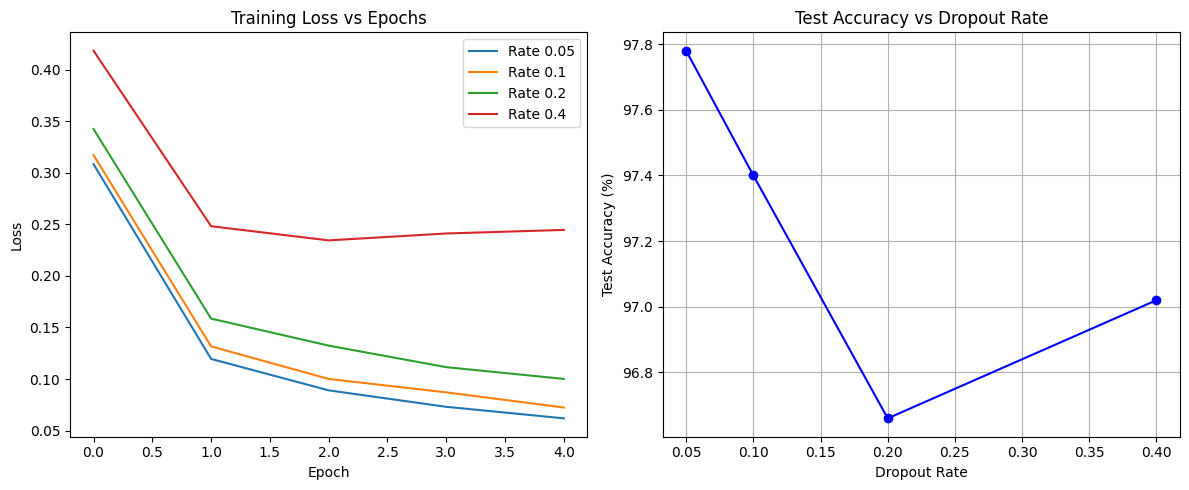

{0.05: {'train_losses': [0.3082819527138394,
   0.11949762659400784,
   0.08901473459852524,
   0.07305157933180016,
   0.06188100079478233],
  'test_accuracy': 97.78},
 0.1: {'train_losses': [0.3170900968120197,
   0.1316256365932318,
   0.10007501072675913,
   0.08707924904466569,
   0.07237212184337637],
  'test_accuracy': 97.4},
 0.2: {'train_losses': [0.3423365125681221,
   0.1585803952778004,
   0.1323746478621671,
   0.11151175621906816,
   0.10010424405772587],
  'test_accuracy': 96.66},
 0.4: {'train_losses': [0.41835608560692145,
   0.24818395817281041,
   0.23444160027599723,
   0.24113947128271918,
   0.24459345177367273],
  'test_accuracy': 97.02}}

In [46]:
DROPOUT_RATES = [0.05, 0.1, 0.2, 0.4]

def compare_dropout_rates(rates, epochs=5, lr=0.9):
    results = {}
    
    for rate in rates:
        print(f"\nTraining with dropout rate: {rate}")
        model = BatchMLPClassifierWithDropout(lr=lr, dropout_rate=rate)
        train_losses = []
        
        # Training
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            for i, (imgs, labels) in enumerate(trainloader):
                X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
                Y = labels
                
                output = model(X)
                loss = batch_cross_entropy(output, Y)
                epoch_loss += loss.item() * len(Y)
                
                model.backward(Y)
                
                if i % 100 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Step [{i}], Loss: {loss:.4f}')
            
            avg_loss = epoch_loss / len(trainset)
            train_losses.append(avg_loss)
            print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')
        
        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        
        for imgs, labels in testloader:
            X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
            output = model(X)
            loss = batch_cross_entropy(output, labels)
            test_loss += loss.item() * len(labels)
            
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
        
        accuracy = 100 * correct / len(testset)
        results[rate] = {
            'train_losses': train_losses,
            'test_accuracy': accuracy
        }
        print(f'Dropout rate {rate}: Test accuracy: {accuracy:.2f}%')
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot training losses
    plt.subplot(121)
    for rate, data in results.items():
        plt.plot(data['train_losses'], label=f'Rate {rate}')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot test accuracies
    plt.subplot(122)
    rates = list(results.keys())
    accuracies = [data['test_accuracy'] for data in results.values()]
    plt.plot(rates, accuracies, 'bo-')
    plt.title('Test Accuracy vs Dropout Rate')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results

compare_dropout_rates(DROPOUT_RATES)


In [130]:
class DeepBatchMLPClassifier:
    def __init__(self, lr, input_dim=784, hidden_dims=[256, 256, 256], output_dim=10):
        self.lr = lr
        
        # Store dimensions for convenience
        self.dims = [input_dim] + hidden_dims + [output_dim]
        
        # First layer
        x_min1 = -np.sqrt(6.0 / (self.dims[0] + self.dims[1]))
        x_max1 = np.sqrt(6.0 / (self.dims[0] + self.dims[1]))
        self.W1 = torch.tensor(np.random.uniform(x_min1, x_max1, (self.dims[1], self.dims[0])), requires_grad=True)
        self.w1 = torch.zeros(self.dims[1], requires_grad=True)
        self.b1 = torch.zeros(self.dims[1], requires_grad=True)
    
        # Second layer
        x_min2 = -np.sqrt(6.0 / (self.dims[1] + self.dims[2]))
        x_max2 = np.sqrt(6.0 / (self.dims[1] + self.dims[2]))
        self.W2 = torch.tensor(np.random.uniform(x_min2, x_max2, (self.dims[2], self.dims[1])), requires_grad=True)
        self.w2 = torch.zeros(self.dims[2], requires_grad=True)
        self.b2 = torch.zeros(self.dims[2], requires_grad=True)
        
        # Third layer
        x_min3 = -np.sqrt(6.0 / (self.dims[2] + self.dims[3]))
        x_max3 = np.sqrt(6.0 / (self.dims[2] + self.dims[3]))
        self.W3 = torch.tensor(np.random.uniform(x_min3, x_max3, (self.dims[3], self.dims[2])), requires_grad=True)
        self.w3 = torch.zeros(self.dims[3], requires_grad=True)
        self.b3 = torch.zeros(self.dims[3], requires_grad=True)
    
        # Output layer
        x_min4 = -np.sqrt(6.0 / (self.dims[3] + self.dims[4]))
        x_max4 = np.sqrt(6.0 / (self.dims[3] + self.dims[4]))
        self.W4 = torch.tensor(np.random.uniform(x_min4, x_max4, (output_dim, self.dims[3])), requires_grad=True)
        self.w4 = torch.zeros(output_dim, requires_grad=True)

    def forward(self):
        # First hidden layer
        self.h1 = self.W1 @ self.X.T + self.w1.unsqueeze(1)
        self.y1 = torch.relu(self.h1) + self.b1.unsqueeze(1)
        
        # Second hidden layer
        self.h2 = self.W2 @ self.y1 + self.w2.unsqueeze(1)
        self.y2 = torch.relu(self.h2) + self.b2.unsqueeze(1)
        
        # Third hidden layer
        self.h3 = self.W3 @ self.y2 + self.w3.unsqueeze(1)
        self.y3 = torch.relu(self.h3) + self.b3.unsqueeze(1)
        
        # Output layer
        self.h4 = self.W4 @ self.y3 + self.w4.unsqueeze(1)
        self.h4 = self.h4 - torch.max(self.h4, dim=0)[0].unsqueeze(0)
        exp_h4 = torch.exp(self.h4)
        self.y4 = exp_h4 / (torch.sum(exp_h4, dim=0).unsqueeze(0) + 1e-8)
        
        return self.y4.T

    def backward(self, Y_true):
        batch_size = len(Y_true)
        
        # Output layer gradients
        dy4 = self.y4.clone()
        dy4.T[range(batch_size), Y_true] -= 1
        dW4 = dy4 @ self.y3.T / batch_size
        dw4 = dy4.mean(dim=1)
        
        # Third layer gradients
        dy3 = self.W4.T @ dy4
        dh3 = dy3 * (self.h3 > 0).float()
        dW3 = dh3 @ self.y2.T / batch_size
        dw3 = dh3.mean(dim=1)
        db3 = dy3.mean(dim=1)
        
        # Second layer gradients
        dy2 = self.W3.T @ dh3
        dh2 = dy2 * (self.h2 > 0).float()
        dW2 = dh2 @ self.y1.T / batch_size
        dw2 = dh2.mean(dim=1)
        db2 = dy2.mean(dim=1)
        
        # First layer gradients
        dy1 = self.W2.T @ dh2
        dh1 = dy1 * (self.h1 > 0).float()
        dW1 = dh1 @ self.X / batch_size
        dw1 = dh1.mean(dim=1)
        db1 = dy1.mean(dim=1)
        
        # Update weights and biases
        with torch.no_grad():
            self.W4 -= self.lr * dW4
            self.w4 -= self.lr * dw4
            
            self.W3 -= self.lr * dW3
            self.w3 -= self.lr * dw3
            self.b3 -= self.lr * db3
            
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.b2 -= self.lr * db2
            
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1
    
    def update_learning_rate(self, epoch, num_epochs):
        self.lr = 0.5 * (1 + np.cos(epoch / num_epochs * np.pi)) * self.lr
        return self.lr

    def __call__(self, X):
        self.X = X
        return self.forward()


In [131]:
model = DeepBatchMLPClassifier(0.5)



In [134]:
for epoch in range(EPOCHS):
    current_lr = model.update_learning_rate(epoch, EPOCHS)
    start = time.time()
    epoch_loss = 0
    for i, (imgs, labels) in enumerate(trainloader):
        X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
        Y = labels
        
        output = model(X)
        loss = criterion(output, Y, batch_cross_entropy)
        epoch_loss += loss.item() * len(Y)
        
        model.backward(Y)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    
    end = time.time()
    delta = end - start
    avg_loss = epoch_loss / len(trainset)
    experiment_results[f'deep_batch_model_e{EPOCHS}']['train_losses'].append(avg_loss)
    experiment_results[f'deep_batch_model_e{EPOCHS}']['epoch_times'].append(delta)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Epoch [1/5], Step [0/60000], Loss: 0.1007
Epoch [1/5], Step [100/60000], Loss: 0.0555
Epoch [1/5], Step [200/60000], Loss: 0.0811
Epoch [1/5], Step [300/60000], Loss: 0.0491
Epoch [1/5], Step [400/60000], Loss: 0.0531
Epoch [1/5], Average Loss: 0.1004
Epoch [2/5], Step [0/60000], Loss: 0.0494
Epoch [2/5], Step [100/60000], Loss: 0.0487
Epoch [2/5], Step [200/60000], Loss: 0.0219
Epoch [2/5], Step [300/60000], Loss: 0.0424
Epoch [2/5], Step [400/60000], Loss: 0.0273
Epoch [2/5], Average Loss: 0.0626
Epoch [3/5], Step [0/60000], Loss: 0.0175
Epoch [3/5], Step [100/60000], Loss: 0.0225
Epoch [3/5], Step [200/60000], Loss: 0.0646
Epoch [3/5], Step [300/60000], Loss: 0.0360
Epoch [3/5], Step [400/60000], Loss: 0.0311
Epoch [3/5], Average Loss: 0.0346
Epoch [4/5], Step [0/60000], Loss: 0.0409
Epoch [4/5], Step [100/60000], Loss: 0.0868
Epoch [4/5], Step [200/60000], Loss: 0.0048
Epoch [4/5], Step [300/60000], Loss: 0.0074
Epoch [4/5], Step [400/60000], Loss: 0.0053
Epoch [4/5], Average Loss:

In [135]:
train_loss = 0
correct = 0

for imgs, labels in trainloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    train_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_train_loss = train_loss / len(trainset)
accuracy = 100 * correct / len(trainset)
experiment_results[f'deep_batch_model_e{EPOCHS}']['train_losses'].append(avg_train_loss)
experiment_results[f'deep_batch_model_e{EPOCHS}']['train_accuracy'] = accuracy

print(f'Train loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%')


Train loss: 0.0134, Accuracy: 99.72%


In [133]:
experiment_results[f"deep_batch_model_e{EPOCHS}"] = {
    "train_accuracy": 0,
    "test_accuracy": 0,
    "train_losses": [],
    "test_losses": [],
    "epoch_times": [],
}


In [136]:
test_loss = 0
correct = 0

for imgs, labels in testloader:
    X = torch.tensor(np.float64(imgs.view(imgs.size(0), -1)))
    output = model(X)
    loss = criterion(output, labels, batch_cross_entropy)
    test_loss += loss.item() * len(labels)
    
    pred = torch.argmax(output, dim=1)
    correct += (pred == labels).sum().item()

avg_test_loss = test_loss / len(testset)
accuracy = 100 * correct / len(testset)
experiment_results[f'deep_batch_model_e{EPOCHS}']['test_losses'].append(avg_test_loss)
experiment_results[f'deep_batch_model_e{EPOCHS}']['test_accuracy'] = accuracy

print(f'Test loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Test loss: 0.0545, Accuracy: 98.32%


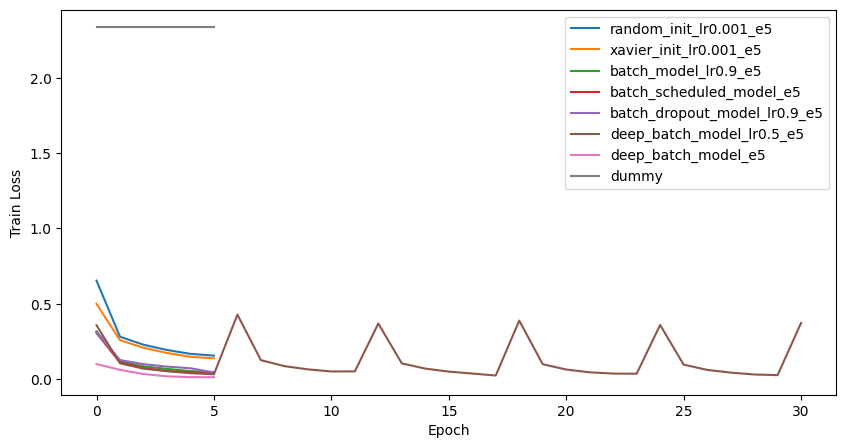

In [151]:
plot_losses({k: v['train_losses'] for k, v in experiment_results.items()})


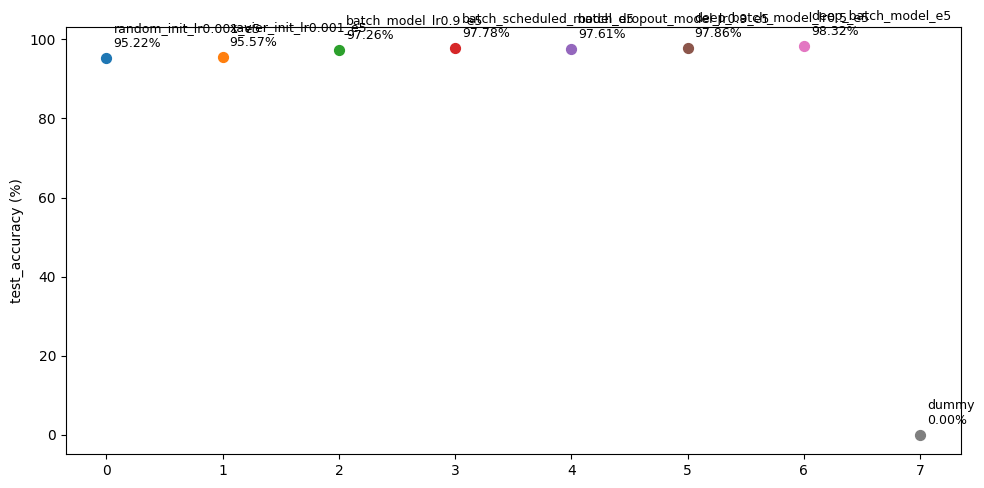

In [152]:
plot_accuracy(experiment_results, "test_accuracy")


In [153]:
experiment_results["deep_batch_model_e5"]


{'train_accuracy': 99.72166666666666,
 'test_accuracy': 98.32,
 'train_losses': [0.10043915843599409,
  0.06264264673866114,
  0.03455541410854667,
  0.019181370760720524,
  0.013976917241483021,
  0.013397671365618525],
 'test_losses': [0.05448856422396602],
 'epoch_times': [3.4856388568878174,
  3.6376287937164307,
  3.218625068664551,
  3.2538888454437256,
  3.165701150894165]}

In [155]:
baseline_accuracy = 0.952  # typical basic neural network accuracy
improvement = ((0.9832 - baseline_accuracy) / baseline_accuracy) * 100
improvement


3.2773109243697487